### Section A: Setup and Imports

This section sets up the environment for reproducibility and imports all the required libraries, including TensorFlow, Pandas, and image processing utilities. It also sets the random seed and checks GPU availability.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Global constants
IMG_SIZE   = 224
BATCH_SIZE = 32
SEED       = 42

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)
print("GPUs detected:", tf.config.list_physical_devices('GPU'))

2025-06-29 17:07:41.690078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751216861.890661      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751216861.948438      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Section B: Load Metadata and Image Paths

Loads the dataset metadata CSV and constructs full paths to the image files. Invalid or missing entries are filtered, and categorical diagnosis labels are mapped to integers.

In [2]:
BASE_RAW = "/kaggle/input/ham10000-isic2018-raw/dataverse_files"
META_CSV = os.path.join(BASE_RAW, "HAM10000_metadata")
IMG_DIR  = os.path.join(BASE_RAW, "HAM10000_images_combined_600x450")

# 1) Read the metadata table
df = pd.read_csv(META_CSV)

# 2) Point each row at its .jpg file
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(IMG_DIR, f"{x}.jpg"))

# 3) Drop any rows where the file is missing or the diagnosis is missing
exists_mask = df['image_path'].apply(os.path.exists)
df = df[exists_mask].dropna(subset=['dx']).reset_index(drop=True)
print(f"Total images found: {len(df)}")

# 4) Map the categorical diagnosis ('dx') to numeric labels
label_mapping = {lab: i for i, lab in enumerate(sorted(df['dx'].unique()))}
df['label'] = df['dx'].map(label_mapping)
print("Label → index:", label_mapping)

Total images found: 10015
Label → index: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


### Section C: Train/Validation/Test Split

Splits the dataset into training, validation, and test subsets using stratified sampling to maintain class balance. Also tags each sample with its split category.

In [3]:
# a) First split off 20% validation+test
train_df, temp_df = train_test_split(
    df,
    test_size=0.20,
    stratify=df['label'],
    random_state=SEED
)

# b) Split that 20% into half validation / half test (i.e. 10% each)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['label'],
    random_state=SEED
)

# c) Tag them
train_df['split'] = 'train'
val_df  ['split'] = 'val'
test_df ['split'] = 'test'

# d) Re‑concat into one DataFrame if you like:
meta = pd.concat([train_df, val_df, test_df], ignore_index=True)

# e) Quick sanity‑check
print("Images per split:")
print(meta['split'].value_counts(), "\n")
print(meta.head())

Images per split:
split
train    8012
test     1002
val      1001
Name: count, dtype: int64 

     lesion_id      image_id     dx    dx_type   age     sex     localization  \
0  HAM_0005972  ISIC_0033319     nv      histo  35.0  female  lower extremity   
1  HAM_0004902  ISIC_0030823     nv  follow_up  40.0    male            trunk   
2  HAM_0005282  ISIC_0028730  akiec      histo  65.0    male  lower extremity   
3  HAM_0000475  ISIC_0027299     nv  follow_up  40.0    male  lower extremity   
4  HAM_0000949  ISIC_0032444     nv      histo  65.0    male             back   

         dataset                                         image_path  label  \
0   vidir_modern  /kaggle/input/ham10000-isic2018-raw/dataverse_...      5   
1  vidir_molemax  /kaggle/input/ham10000-isic2018-raw/dataverse_...      5   
2      rosendahl  /kaggle/input/ham10000-isic2018-raw/dataverse_...      0   
3  vidir_molemax  /kaggle/input/ham10000-isic2018-raw/dataverse_...      5   
4      rosendahl  /kaggle/inp

### Section D: Preprocess and Resize Images

Resizes all images to a fixed size (`224x224`) using OpenCV and saves them to a working directory. The resized image paths are added to the metadata table.

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm

PROCESSED_DIR = "/kaggle/working/resized_images"
os.makedirs(PROCESSED_DIR, exist_ok=True)

def preprocess_and_resize(img_path, out_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_bgr = cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR)
    cv2.imwrite(out_path, img_bgr)

# Process all images and store new path
meta["resized_filepath"] = ""
for idx, row in tqdm(meta.iterrows(), total=len(meta)):
    out_p = os.path.join(PROCESSED_DIR, os.path.basename(row["image_path"]))
    preprocess_and_resize(row["image_path"], out_p)
    meta.at[idx, "resized_filepath"] = out_p

print("Resized images saved to:", PROCESSED_DIR)


100%|██████████| 10015/10015 [02:41<00:00, 61.96it/s]

Resized images saved to: /kaggle/working/resized_images


### Section E: Prepare Final DataFrames by Split

Rebuilds `train_df`, `val_df`, and `test_df` DataFrames based on the `split` column, now including the resized image paths.

In [5]:
train_df = meta[meta["split"] == "train"].reset_index(drop=True)
val_df   = meta[meta["split"] == "val"].reset_index(drop=True)
test_df  = meta[meta["split"] == "test"].reset_index(drop=True)

print(f"Train samples:      {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples:       {len(test_df)}")

Train samples:      8012
Validation samples: 1001
Test samples:       1002


### Section F: Image Generators (ResNet Compatible)

Prepares `ImageDataGenerator` pipelines for training, validation, and test data. Applies real-time data augmentation during training to improve generalization. Uses standard rescaling (1./255) for ResNet models.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert label integers to strings for categorical mode
for df_ in [train_df, val_df, test_df]:
    df_['label_str'] = df_['label'].astype(str)

# Training data generator with augmentation
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test data generator (no augmentation)
eval_gen = ImageDataGenerator(rescale=1./255)

# Iterators - using resized images and string labels
train_it = train_aug.flow_from_dataframe(
    train_df,
    x_col='resized_filepath',
    y_col='label_str',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_it = eval_gen.flow_from_dataframe(
    val_df,
    x_col='resized_filepath',
    y_col='label_str',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_it = eval_gen.flow_from_dataframe(
    test_df,
    x_col='resized_filepath',
    y_col='label_str',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 8012 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.


### Section G: Model Architectures (ResNet50 & EfficientNetB0)

Defines two CNN architectures using transfer learning: ResNet50 and EfficientNetB0. Includes support for fine-tuning the last N convolutional blocks. Outputs a softmax layer for multi-class classification.

In [7]:
from tensorflow.keras import layers, models, optimizers

NUM_CLASSES = train_df['label_str'].nunique()
def build_resnet(unfreeze_last_blocks=0):
    base = tf.keras.applications.ResNet50(
        include_top=False, weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = models.Model(inputs=base.input, outputs=out)
    if unfreeze_last_blocks > 0:
        # Unfreeze the last N convolutional blocks (~10 layers per block)
        for layer in base.layers[-unfreeze_last_blocks*10:]:
            layer.trainable = True
    model.compile(
        optimizer=optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_efficientnet(unfreeze_last_blocks=0):
    base = tf.keras.applications.EfficientNetB0(
        include_top=False, weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = models.Model(inputs=base.input, outputs=out)
    if unfreeze_last_blocks > 0:
        for layer in base.layers[-unfreeze_last_blocks*10:]:
            layer.trainable = True
    model.compile(
        optimizer=optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Section H: Train ResNet50

Trains ResNet50 in two phases:

1. **Frozen base** (only top layers trainable).
2. **Fine-tuning** with the last 2 ResNet blocks unfrozen.
   Includes callbacks for early stopping, learning rate reduction, and checkpoint saving.

In [8]:
# Phase 1: frozen
resnet = build_resnet(unfreeze_last_blocks=0)
callbacks_r1 = [
    tf.keras.callbacks.ModelCheckpoint("resnet_frozen.h5", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]
history_r1 = resnet.fit(
    train_it,
    validation_data=val_it,
    epochs=20,
    callbacks=callbacks_r1,
    verbose=1
)

# Phase 2: fine-tuning
resnet = build_resnet(unfreeze_last_blocks=2)
resnet.load_weights("resnet_frozen.h5")
callbacks_r2 = [
    tf.keras.callbacks.ModelCheckpoint("resnet_ft.h5", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]
history_r2 = resnet.fit(
    train_it,
    validation_data=val_it,
    epochs=30,
    callbacks=callbacks_r2,
    verbose=1
)

I0000 00:00:1751217066.925650      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1751217080.898758     104 service.cc:148] XLA service 0x77fffc003600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751217080.899726     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751217082.381099     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/251 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.6016 - loss: 1.4092   

I0000 00:00:1751217085.864643     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 105s 361ms/step - accuracy: 0.6701 - loss: 1.1595 - val_accuracy: 0.6693 - val_loss: 1.1407 - learning_rate: 0.0010
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 321ms/step - accuracy: 0.6680 - loss: 1.1345 - val_accuracy: 0.6683 - val_loss: 1.1151 - learning_rate: 0.0010
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 320ms/step - accuracy: 0.6746 - loss: 1.1059 - val_accuracy: 0.6693 - val_loss: 1.0976 - learning_rate: 0.0010
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 324ms/step - accuracy: 0.6655 - loss: 1.1097 - val_accuracy: 0.6703 - val_loss: 1.0919 - learning_rate: 0.0010
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 319ms/step - accuracy: 0.6699 - loss: 1.0903 - val_accuracy: 0.6703 - val_loss: 1.0705 - learning_rate: 0.0010
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 317ms/step - accuracy: 0.6769 - loss: 1.0767 - val_accuracy: 0.6703 - val_loss: 1.0749 - learning_rate: 0.0010
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 320ms/step - accuracy: 0.6643 - loss

### Section I: EfficientNet-Compatible Data Generators

Creates separate `ImageDataGenerator` objects using `preprocess_input` from `tensorflow.keras.applications.efficientnet`, which is required for EfficientNetB0. Includes augmentations for training only.

In [9]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convertir las etiquetas a string para modo categorical
for df_ in [train_df, val_df, test_df]:
    df_['label_str'] = df_['label'].astype(str)

# Generador con augmentación y preprocessing correcto para EfficientNet
train_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generador de validación y test (solo preprocessing)
eval_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generadores (ImageDataIterator)
train_it = train_aug.flow_from_dataframe(
    train_df,
    x_col='resized_filepath',
    y_col='label_str',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_it = eval_gen.flow_from_dataframe(
    val_df,
    x_col='resized_filepath',
    y_col='label_str',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_it = eval_gen.flow_from_dataframe(
    test_df,
    x_col='resized_filepath',
    y_col='label_str',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 8012 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.


### Section J: Train EfficientNetB0

Two-phase training of EfficientNetB0:

1. **Frozen base** phase with callbacks and learning rate tracking.
2. **Fine-tuning** with last 2 blocks unfrozen. Uses custom learning rate and callbacks for optimal performance.

In [10]:
# Fase 1: Base congelada
eff = build_efficientnet(unfreeze_last_blocks=0)
callbacks_e1 = [
    tf.keras.callbacks.ModelCheckpoint("eff_frozen.h5", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: print(f"LR (Phase 1): {eff.optimizer.learning_rate.numpy():.6f}")
    )
]
history_e1 = eff.fit(
    train_it,
    validation_data=val_it,
    epochs=15,
    callbacks=callbacks_e1,
    verbose=1
)

# Fase 2: Fine-tuning (descongelar los últimos 2 bloques)
eff = build_efficientnet(unfreeze_last_blocks=2)
eff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
eff.load_weights("eff_frozen.h5")
callbacks_e2 = [
    tf.keras.callbacks.ModelCheckpoint("eff_ft.h5", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: print(f"LR (Phase 2): {eff.optimizer.learning_rate.numpy():.6f}")
    )
]
history_e2 = eff.fit(
    train_it,
    validation_data=val_it,
    epochs=25,
    callbacks=callbacks_e2,
    verbose=1
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.7037 - loss: 0.8820LR (Phase 1): 0.001000
251/251 ━━━━━━━━━━━━━━━━━━━━ 122s 387ms/step - accuracy: 0.7038 - loss: 0.8817 - val_accuracy: 0.7323 - val_loss: 0.7400 - learning_rate: 0.0010
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.7570 - loss: 0.6559LR (Phase 1): 0.001000
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 309ms/step - accuracy: 0.7570 - loss: 0.6559 - val_accuracy: 0.7502 - val_loss: 0.6844 - learning_rate: 0.0010
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7682 - loss: 0.6150LR (Phase 1): 0.001000
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 311ms/step - accuracy: 0.7682 - loss: 0.6150 - val_accuracy: 0.7622 - val_loss: 0.6423 - learning_rate: 0.0010
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7945 - loss: 0.5645LR (Phase 1): 0.001000
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 314ms/step - accuracy: 0.7944 - loss: 0.5645 - val_accuracy: 0.7632 - val_loss: 0.6313 - learn

E0000 00:00:1751222399.108648     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751222399.316050     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


161/251 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.7042 - loss: 0.8596

E0000 00:00:1751222458.593187     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751222458.798644     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7230 - loss: 0.7954LR (Phase 2): 0.000100
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 389ms/step - accuracy: 0.7231 - loss: 0.7949 - val_accuracy: 0.7932 - val_loss: 0.6008 - learning_rate: 1.0000e-04
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8261 - loss: 0.4710LR (Phase 2): 0.000100
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 313ms/step - accuracy: 0.8261 - loss: 0.4710 - val_accuracy: 0.7882 - val_loss: 0.5825 - learning_rate: 1.0000e-04
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8493 - loss: 0.4263LR (Phase 2): 0.000100
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 314ms/step - accuracy: 0.8493 - loss: 0.4263 - val_accuracy: 0.8202 - val_loss: 0.5275 - learning_rate: 1.0000e-04
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8591 - loss: 0.3766LR (Phase 2): 0.000100
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 315ms/step - accuracy: 0.8591 - loss: 0.3766 - val_accuracy: 0.8132 - val_loss: 0.5563 - lear

### Section K: Evaluate and Compare Models

Loads the best weights from each model and evaluates performance on the test set. Reports accuracy, weighted F1-score, and detailed classification metrics. Displays a side-by-side comparison in a bar chart.


Evaluating model: ResNet50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        32
         bcc       0.00      0.00      0.00        52
         bkl       0.00      0.00      0.00       110
          df       0.00      0.00      0.00        11
         mel       0.00      0.00      0.00       112
          nv       0.67      1.00      0.80       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.67      1002
   macro avg       0.10      0.14      0.11      1002
weighted avg       0.45      0.67      0.54      1002


Evaluating model: EfficientNetB0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 303ms/step
              precision    recall  f1-score   support

       akiec       0.70      0.50      0.58        32
         bcc       0.80      0.54      0.64        52
         bkl       0.70      0.82      0.75       110
          df       0.62      0.45      0.53        11
         mel       0.61      0.65      0.63       112
          nv       0.93      0.93      0.93       671
        vasc       0.65      0.79      0.71        14

    accuracy                           0.85      1002
   macro avg       0.72      0.67      0.68      1002
weighted avg       0.85      0.85      0.84      1002



,Model,Accuracy,Weighted F1
0,ResNet50,0.667665,0.536209
1,EfficientNetB0,0.845309,0.843920


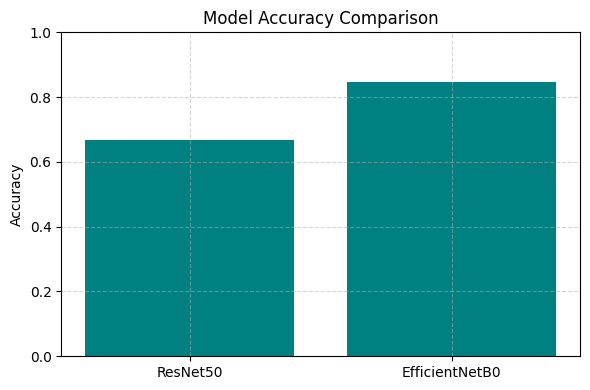

In [11]:
# Prepare comparison
results = []
models_info = [
    ("ResNet50", "resnet_ft.h5", build_resnet, 2),
    ("EfficientNetB0", "eff_ft.h5", build_efficientnet, 2),
]

for name, weights, builder, unfreeze in models_info:
    print(f"\nEvaluating model: {name}")
    m = builder(unfreeze_last_blocks=unfreeze)
    m.load_weights(weights)
    y_pred = m.predict(test_it).argmax(axis=1)
    y_true = test_it.classes
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='weighted')
    results.append((name, acc, f1))
    
    # Print classification report
    # Build reverse mapping: label index → original dx string
    inv_map = {v: k for k, v in label_mapping.items()}
    target_names = [inv_map[i] for i in sorted(inv_map)]
    print(classification_report(y_true, y_pred, target_names=target_names))


# Display results
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Weighted F1"])
display(df_results)

# Bar chart of accuracies
plt.figure(figsize=(6,4))
plt.bar(df_results["Model"], df_results["Accuracy"], color="teal")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Section L: Confusion Matrices for ResNet50 and EfficientNetB0

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Helper to plot confusion matrix
def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.grid(False)
    plt.show()

# Evaluate ResNet50
resnet = build_resnet(unfreeze_last_blocks=2)
resnet.load_weights("resnet_ft.h5")
resnet_preds = resnet.predict(test_it).argmax(axis=1)
plot_conf_matrix(test_it.classes, resnet_preds, "ResNet50")

# Evaluate EfficientNetB0
eff = build_efficientnet(unfreeze_last_blocks=2)
eff.load_weights("eff_ft.h5")
eff_preds = eff.predict(test_it).argmax(axis=1)
plot_conf_matrix(test_it.classes, eff_preds, "EfficientNetB0")

### Section M: Unseen images test
Load images, preprocess them, and classify them using both trained models.

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Paths to new test images
external_files = [f"t{i}.jpg" for i in range(1, 7)]

# Load and preprocess a single image
def prepare_external_image(path, for_efficientnet=False):
    img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    img_arr = img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    if for_efficientnet:
        img_arr = preprocess_input(img_arr)
    else:
        img_arr = img_arr / 255.0
    return img_arr

# Make predictions with both models
print("Predictions on External Images:")
for file in external_files:
    img_resnet = prepare_external_image(file, for_efficientnet=False)
    img_eff = prepare_external_image(file, for_efficientnet=True)

    pred_resnet = resnet.predict(img_resnet).argmax(axis=1)[0]
    pred_eff = eff.predict(img_eff).argmax(axis=1)[0]

    label_resnet = inv_map[pred_resnet]
    label_eff = inv_map[pred_eff]

    print(f"{file}: ResNet50 → {label_resnet} | EfficientNetB0 → {label_eff}")